In [1]:
from gym import utils
from gym.envs.toy_text import discrete

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from tf_tsallis_statistics import *
print('Load Packages')

Load Packages


In [27]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "SIMPLE": [
        "SFFF",
        "FFFF",
        "FFFF",
        "FFFG"
    ],
    "1-HOLE": [
        "SFFF",
        "FHFF",
        "FFFF",
        "FFFG"
    ],
    "3-HOLE": [
        "SFFH",
        "FHFF",
        "FHFF",
        "FFFG"
    ],
    "4-HOLE": [
        "SFFH",
        "FHFF",
        "FHFF",
        "FFHG"
    ]
}

class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    R : random hole, fall to your doom or not
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="SIMPLE",is_slippery=True):
        if desc is None and map_name is None:
            raise ValueError('Must provide either desc or map_name')
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s : {a : [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col
        
        def inc(row, col, a):
            if a==0: # left
                col = max(col-1,0)
            elif a==1: # down
                row = min(row+1,nrow-1)
            elif a==2: # right
                col = min(col+1,ncol-1)
            elif a==3: # up
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a-1)%4, a, (a+1)%4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                if newletter == b'G':
                                    rew = 2
                                elif newletter == b'H':
                                    rew = -0.5
                                else:    
                                    rew = 0
                                
                                if b == a:
                                    li.append((0.8, newstate, rew, done))
                                else:
                                    li.append((0.1, newstate, rew, done))
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            return outfile

In [28]:
env = FrozenLakeEnv(map_name='4-HOLE')

obs_space = env.observation_space
n_state = obs_space.n
print('Observation space')
print("Total {} states".format(n_state))

act_space = env.action_space
n_act = act_space.n
print('Action space')
print("Total {} actions".format(n_act))

Observation space
Total 16 states
Action space
Total 4 actions


In [33]:
def value_iteration(env,gamma=0.9,epsilon=1e-4):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward
                
    value = np.random.uniform(size=(n_state,))
    
    while True: 
        q = np.sum((r+gamma*np.tile(value[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2)
        v_prime = np.max(q,axis=1)
        v_prime = v_prime.reshape(-1,)
        dist = np.max(np.abs(value-v_prime))
        value = v_prime
        if dist < epsilon:
            break
            
    policy = np.zeros([n_state,n_act])
    policy[np.arange(n_state),np.argmax(q, axis=1)] = 1.0
    return policy, value

def tsallis_value_iteration(env,gamma=0.9,epsilon=1e-4, q_index =1.0, temperature=1e-3):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward
                
    r = r/temperature
    value = np.random.uniform(size=(n_state,))
    
    while True: 
        q = np.sum((r+gamma*np.tile(value[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2)
        v_prime,_ = np_max_q(q,q=q_index)
        v_prime = v_prime.reshape(-1,)
        dist = np.max(np.abs(value-v_prime))
        value = v_prime
        if dist < epsilon:
            break
            
    _, policy = np_max_q(q,q=q_index)
    return policy, value

def policy_evaluation(env,policy,gamma=0.9,epsilon=1e-4):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward
                    
    value = np.random.uniform(size=(n_state,))
    
    while True: 
        q = np.sum((r+gamma*value[np.newaxis,np.newaxis,:])*P,axis=2)
        v_prime = np.sum(q*policy,axis=1)
        v_prime = v_prime.reshape(-1,)
        dist = np.max(np.abs(value-v_prime))
        value = v_prime
        if dist < epsilon:
            break
    return value
            
def plot_results(policy, value, title="Value Function"):
    plt.figure(num=0)
    plt.imshow(np.reshape(value,(8,8)))
    plt.title(title)  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,alpha=policy[s][0], head_width=0.1, head_length=0.2, fc='r', ec='r')
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,alpha=policy[s][1], head_width=0.1, head_length=0.2, fc='r', ec='r')
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,alpha=policy[s][2], head_width=0.1, head_length=0.2, fc='r', ec='r')
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,alpha=policy[s][3], head_width=0.1, head_length=0.2, fc='r', ec='r')
    plt.show()
    
if __name__=='__main__':
    temp = 1e-1
    gamma = 0.7
    policy, value = value_iteration(env,gamma=gamma)
    value = policy_evaluation(env,policy,gamma=gamma)
    
    J_opt = value[0]
    
    q_list = [1.0,1.2,1.5,1.7,2.0,2.5,3.0,5.0,7.0,10.0]
    
    upper_list = J_opt*np.ones_like(q_list)
    lower_list = J_opt*np.ones_like(q_list)
    J_q_list = np.zeros_like(q_list)
    
    for q_idx in range(len(q_list)):
        q=q_list[q_idx]
        
        lower_list[q_idx] = lower_list[q_idx] + temp*1/(1-gamma)*np_log_q(np.array(1/4.),q=2.-q)
        
        policy, value = tsallis_value_iteration(env,gamma=gamma,q_index=2-q,temperature=temp)
        value = policy_evaluation(env,policy,gamma=gamma)
        J_q_list[q_idx] = value[0]

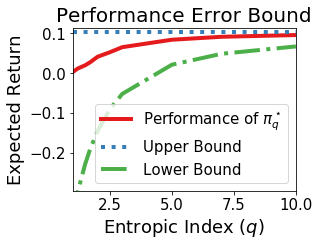

In [90]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.figure(figsize=(4,3))
cmap = cm.get_cmap('Set1')
color_list=cmap(np.linspace(0,0.3,3))
plt.plot(q_list,J_q_list,label=r"Performance of $\pi^\star_q$",color=color_list[0],linestyle="-",lw=4)
plt.plot(q_list,upper_list,label="Upper Bound",color=color_list[1],linestyle=":",lw=4)
plt.plot(q_list,lower_list,label="Lower Bound",color=color_list[2],linestyle="-.",lw=4)
plt.title("Performance Error Bound".format(q),size=BIGGER_SIZE)
plt.xlim([np.min(q_list),np.max(q_list)])
plt.xlabel(r"Entropic Index ($q$)")
plt.ylim([J_opt-0.4,J_opt+0.01])
plt.ylabel(r"Expected Return")
plt.legend()
plt.show()

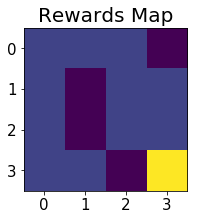

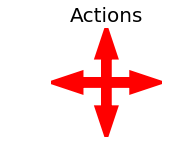

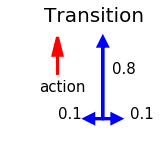

In [168]:
nrow = ncol =4
rew_map = np.zeros([nrow,ncol])
for row in range(nrow):
    for col in range(ncol):
        newletter = env.desc[row][col]
        if newletter == b'G':
            rew = 2
        elif newletter == b'H':
            rew = -0.5
        else:    
            rew = 0
        rew_map[row,col] = rew
        
plt.figure(figsize=(4,3))
plt.imshow(rew_map)
plt.xticks([0,1,2,3])
plt.yticks([0,1,2,3])
plt.title("Rewards Map",size=BIGGER_SIZE)
plt.show()
 
plt.figure(figsize=(2,2))
arr_len = 0.5
plt.arrow(0,0,-arr_len,0, head_width=0.2, head_length=0.3, lw=10, fc='r', ec='r')
plt.arrow(0,0,0,arr_len, head_width=0.2, head_length=0.3, lw=10, fc='r', ec='r')
plt.arrow(0,0,arr_len,0, head_width=0.2, head_length=0.3, lw=10, fc='r', ec='r')
plt.arrow(0,0,0,-arr_len, head_width=0.2, head_length=0.3, lw=10, fc='r', ec='r')
plt.axis('equal')
plt.axis('off')
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
plt.title("Actions",size=BIGGER_SIZE)
plt.show()

plt.figure(figsize=(2,2))
arr_len = 1.0
plt.arrow(-0.4,0.5,0,arr_len*0.2, head_width=0.1, head_length=0.2, lw=3, fc='r', ec='r')
plt.arrow(0.1,0,-arr_len*0.1,0, head_width=0.1, head_length=0.1, lw=3, fc='b', ec='b')
plt.arrow(0.1,0,0,arr_len*0.8, head_width=0.1, head_length=0.1, lw=3, fc='b', ec='b')
plt.arrow(0.1,0,arr_len*0.1,0, head_width=0.1, head_length=0.1, lw=3, fc='b', ec='b')
plt.text(-0.6, 0.3, 'action', fontsize=15)
plt.text(0.2, 0.5, '0.8', fontsize=15)
plt.text(0.4, 0, '0.1', fontsize=15)
plt.text(-0.4,0, '0.1', fontsize=15)
plt.axis('equal')
plt.axis('off')
plt.xlim([-1.0,1.0])
plt.ylim([-0.2,1.0])
plt.title("Transition",size=BIGGER_SIZE)
plt.show()